### Step 1: Convolution ninja

In [46]:
import torch
import torch.nn as nn
import torch.functional as F

In [47]:
# Create a basic convnet model taking as input a tensor of size B x 3 x 224 x 224
# and containing the following layers:
# - a 2D convolution with output dim = 64, kernel size = 7, stride = 2, padding = 3
# - a batch norm
# - a ReLU
# - a 2D max pooling with kernel size = 3, stride = 2 and padding = 1
# - a 2D avg pooling with input dim you should guess using .shape and stride = 1
# - a flatten layer
# - a linear layer with input dim you should guess using .shape and output dim = 10
#
# Leave all bias options unchanged (i.e. true by default)
#
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [48]:
torch.set_printoptions(precision=8)

In [49]:
torch.manual_seed(123) # do not remove this line
X = torch.rand((3, 3, 224, 224))
torch.manual_seed(123) # do not remove this line
m = Net()

In [50]:
out = m(X)

In [51]:
# Sanity check. This should return True.
torch.allclose(out, torch.tensor([[ 0.23229745,  0.49533808, -0.94218129,  0.80567420, -1.08792305,
         -0.08189888,  0.75406575, -1.52529275,  0.54173046, -0.29273897],
        [ 0.22363546,  0.49459273, -0.93474990,  0.82280755, -1.07130551,
         -0.09333123,  0.75027251, -1.52482963,  0.53764951, -0.28636456],
        [ 0.22320433,  0.49914300, -0.93878180,  0.81160194, -1.07520950,
         -0.09055193,  0.76426411, -1.52148080,  0.54697251, -0.29279822]]))

True

### Step 2: Build a Plain Net
Use the notebook to build your architecture. Make sure that inference works before running a training. Do not modify the dataset code.

In [52]:
import gc
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

In [53]:
# compute mean and variance of the CIFAR10 dataset - do not modify this code
from torchvision import datasets
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.CIFAR10(root='files/', train=True, download=True, transform=train_transform)
print(train_set.data.mean(axis=(0,1,2))/255)
print(train_set.data.std(axis=(0,1,2))/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [54]:
batch_size = 64

In [55]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./files',
                                         batch_size=64)

test_loader = data_loader(data_dir='./files',
                              batch_size=batch_size,
                              test=True)
                              
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = 10

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


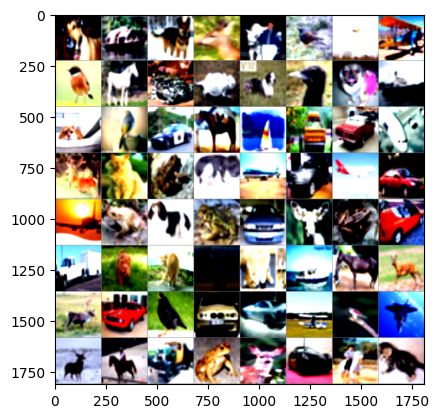

dog   ship  dog   deer  horse bird  plane plane bird  horse frog  frog  dog   bird  dog   ship  cat   bird  car   horse ship  truck car   plane deer  cat   frog  cat   plane car   plane car   plane frog  dog   frog  car   deer  frog  car   truck dog   cat   deer  cat   ship  horse deer  deer  car   bird  car   car   plane bird  plane deer  horse truck frog  deer  car   horse cat  


torch.Size([3, 224, 224])

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
images[0].shape

In [59]:
# use this cell as a sandbox to dry-run your architecture and make sure you understand the shapes
it = iter(train_loader)
images, labels = next(it)
x = images
f1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
print(x.shape, f1(x).shape)

torch.Size([64, 3, 224, 224]) torch.Size([64, 64, 112, 112])


In [60]:
# Build a PlainNet architecture as described in the paper: https://arxiv.org/pdf/1512.03385.pdf
#
# The module takes as input the number of convolutions at each layer (e.g. [6, 7, 11, 5] for a PlainNet-34)
#
# Use a for loop for layers 2-5, e.g.:
#
# layer2 = []
# for _ in range(n):
#     layer2 += [nn.Conv2d(...), nn.BatchNorm(...), nn.ReLU()]
# self.layer2 = nn.Sequential (layer2)
#

class PlainNet(nn.Module):
    def __init__(self, output_dim, layers):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        layer2 = [
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]
        for _ in range(layers[0]):
            layer2 += [
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), # fill in the arguments
                nn.BatchNorm2d(64), # fill in the arguments
                nn.ReLU(),
            ]
        self.layer2 = nn.Sequential(*layer2)

        # same for layers 3, 4 and 5
        layer3 = [
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ]
        for _ in range(layers[1]):
            layer3 += [
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False), # fill in the arguments
                nn.BatchNorm2d(128), # fill in the arguments
                nn.ReLU(),
            ]
        self.layer3 = nn.Sequential(*layer3)

        layer4 = [
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        ]
        for _ in range(layers[2]):
            layer4 += [
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), # fill in the arguments
                nn.BatchNorm2d(256), # fill in the arguments
                nn.ReLU(),
            ]
        self.layer4 = nn.Sequential(*layer4)

        layer5 = [
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        ]
        for _ in range(layers[3]):
            layer5 += [
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False), # fill in the arguments
                nn.BatchNorm2d(512), # fill in the arguments
                nn.ReLU(),
            ]
        self.layer5 = nn.Sequential(*layer5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(512, output_dim)) # fill in the arguments

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        # use x = x.reshape(x.size(0), -1) or a nn.Flatten() layer  before the linear layer
        return x

In [61]:
model = PlainNet(num_classes, layers=[4, 3, 3, 3]).to(device) # plain-18
print(f'plain-18: {count_parameters(model)}')
# expected answer: 11,529,602

plain-18: 11044810


In [62]:
model = PlainNet(num_classes, layers=[6, 7, 11, 5]).to(device) # plain-34
print(f'plain-34: {count_parameters(model)}')
# expected answer: 21,641,474

plain-34: 21152970


In [63]:
# check that your model can infer correctly
# expected answer: torch.Size([64, 10])

X = torch.rand((64,3,224,224))
model(X).shape

torch.Size([64, 10])

### Train the model
Do not modify the training code

In [64]:
# these parameters should work to train your models
num_epochs = 20
batch_size = 16
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

In [65]:
def train(model):

    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        print ('Epoch [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, loss.item()))
                
        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
        
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

### Step 3: Build a ResNet

In [66]:
# Build a ResidualBlock (i.e regular ResNet block)
#
# - a 2D convolution with input dim = in_channels, output dim = out_channels, kernel size = 3, stride = stride, padding = 1 and bias = False
#   (followed by a batchnorm and a ReLU)
# - a 2D convolution with input dim = out_channels, output dim = out_channels, kernel size = 3, stride = 1, padding = 1 and bias = False
#   (followed by a batchnorm and a ReLU)
#
#  x -------> conv1 + BN + ReLU ---------> conv2 + BN -------------- + ----- ReLU ------> out
#        |                                                           |
#         ---------------------- downsample -------------------------
#

class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, stride=1,
                      padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.out_channels = out_channels

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [67]:
# Sanity check
torch.manual_seed(123)
X = torch.rand((1,4,3,3))
torch.manual_seed(123)
m = ResidualBlock(4, 4, stride=1, downsample=None)
out = m(X)

In [68]:
torch.allclose(out, torch.tensor([[[[1.68696165, 0.04760247, 0.00000000],
          [0.59837186, 1.38795805, 1.91975749],
          [0.00000000, 0.00000000, 0.00000000]],
         [[1.83508623, 0.18320152, 1.34237385],
          [0.00000000, 0.00000000, 0.00000000],
          [1.56650257, 0.82063377, 1.10089588]],
         [[1.69185019, 1.08052707, 1.43224478],
          [0.00000000, 0.00000000, 0.70441115],
          [1.32906127, 0.19663277, 0.80512488]],
         [[0.00000000, 1.80850124, 0.92189598],
          [0.00000000, 1.95879388, 0.53320688],
          [0.97944093, 0.00000000, 1.19880044]]]]))

True

In [69]:
# Build a Bottleneck block
#
# - a 2D convolution with input dim = in_channels, output dim = out_channels, kernel size = 1, bias = False
#   (followed by a batchnorm and a ReLU)
# - a 2D convolution with input dim = out_channels, output dim = out_channels, kernel size = 3, stride = stride, padding = 1 and bias = False
#   (followed by a batchnorm and a ReLU)
# - a 2D convolution with input dim = out_channels, output dim = out_channels * self.expansion, kernel size = 1, bias = False
#   (followed by a batchnorm and a ReLU)
#
#  x -------> conv1 + BN + ReLU --> conv2 + BN + ReLU --> conv3 + BN ------------ + ------- ReLU ------> out
#        |                                                                        |
#         ------------------------------- downsample -----------------------------
#
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, stride=stride,
                      padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * self.expansion,
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )

        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [70]:
# Sanity check
torch.manual_seed(123)
X = torch.rand((1,4,3,3))
torch.manual_seed(123)
m = Bottleneck(4, 1, stride=1, downsample=None)
out = m(X)

In [71]:
torch.allclose(out, torch.tensor([[[[0.87262857, 0.87095368, 0.00000000],
          [0.00000000, 0.65048909, 0.78769910],
          [0.71309650, 0.67899567, 0.76057309]],
         [[1.30293083, 0.66962528, 0.16133851],
          [0.00000000, 0.77312225, 0.23759353],
          [0.97822422, 0.69505239, 1.40387940]],
         [[0.95844048, 1.01478648, 0.32792020],
          [0.00000000, 1.21308136, 0.90382838],
          [0.85085136, 1.23473167, 0.85389799]],
         [[1.43384838, 1.25372386, 0.00000000],
          [0.00000000, 1.31528068, 0.63905966],
          [1.28236103, 1.49217308, 1.01050377]]]]))

True

In [72]:
# do not modify this class

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [73]:
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device) #resnet-18
print(count_parameters(model))
# expected answer: 11,181,642

11181642


In [74]:
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device) #resnet-34
print(count_parameters(model))
# expected answer: 21,289,802

21289802


In [75]:
model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device) #resnet-50
print(count_parameters(model))
# expected answer: 23,528,522

23528522


In [76]:
# sanity check: print the number of parameters for official resnet models
model = torchvision.models.resnet50(num_classes=10)
print(count_parameters(model))

23528522


### Optional: visualize the filters and activation maps

#### PlainNet-18 model

In [77]:
# load a model (saved after training)
model = PlainNet(num_classes, layers=[4, 3, 3, 3])
model.load_state_dict(torch.load('models/plain-18-sd.bin', map_location=torch.device('cpu')))

<All keys matched successfully>

In [78]:
model

PlainNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [79]:
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i]:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 18


64


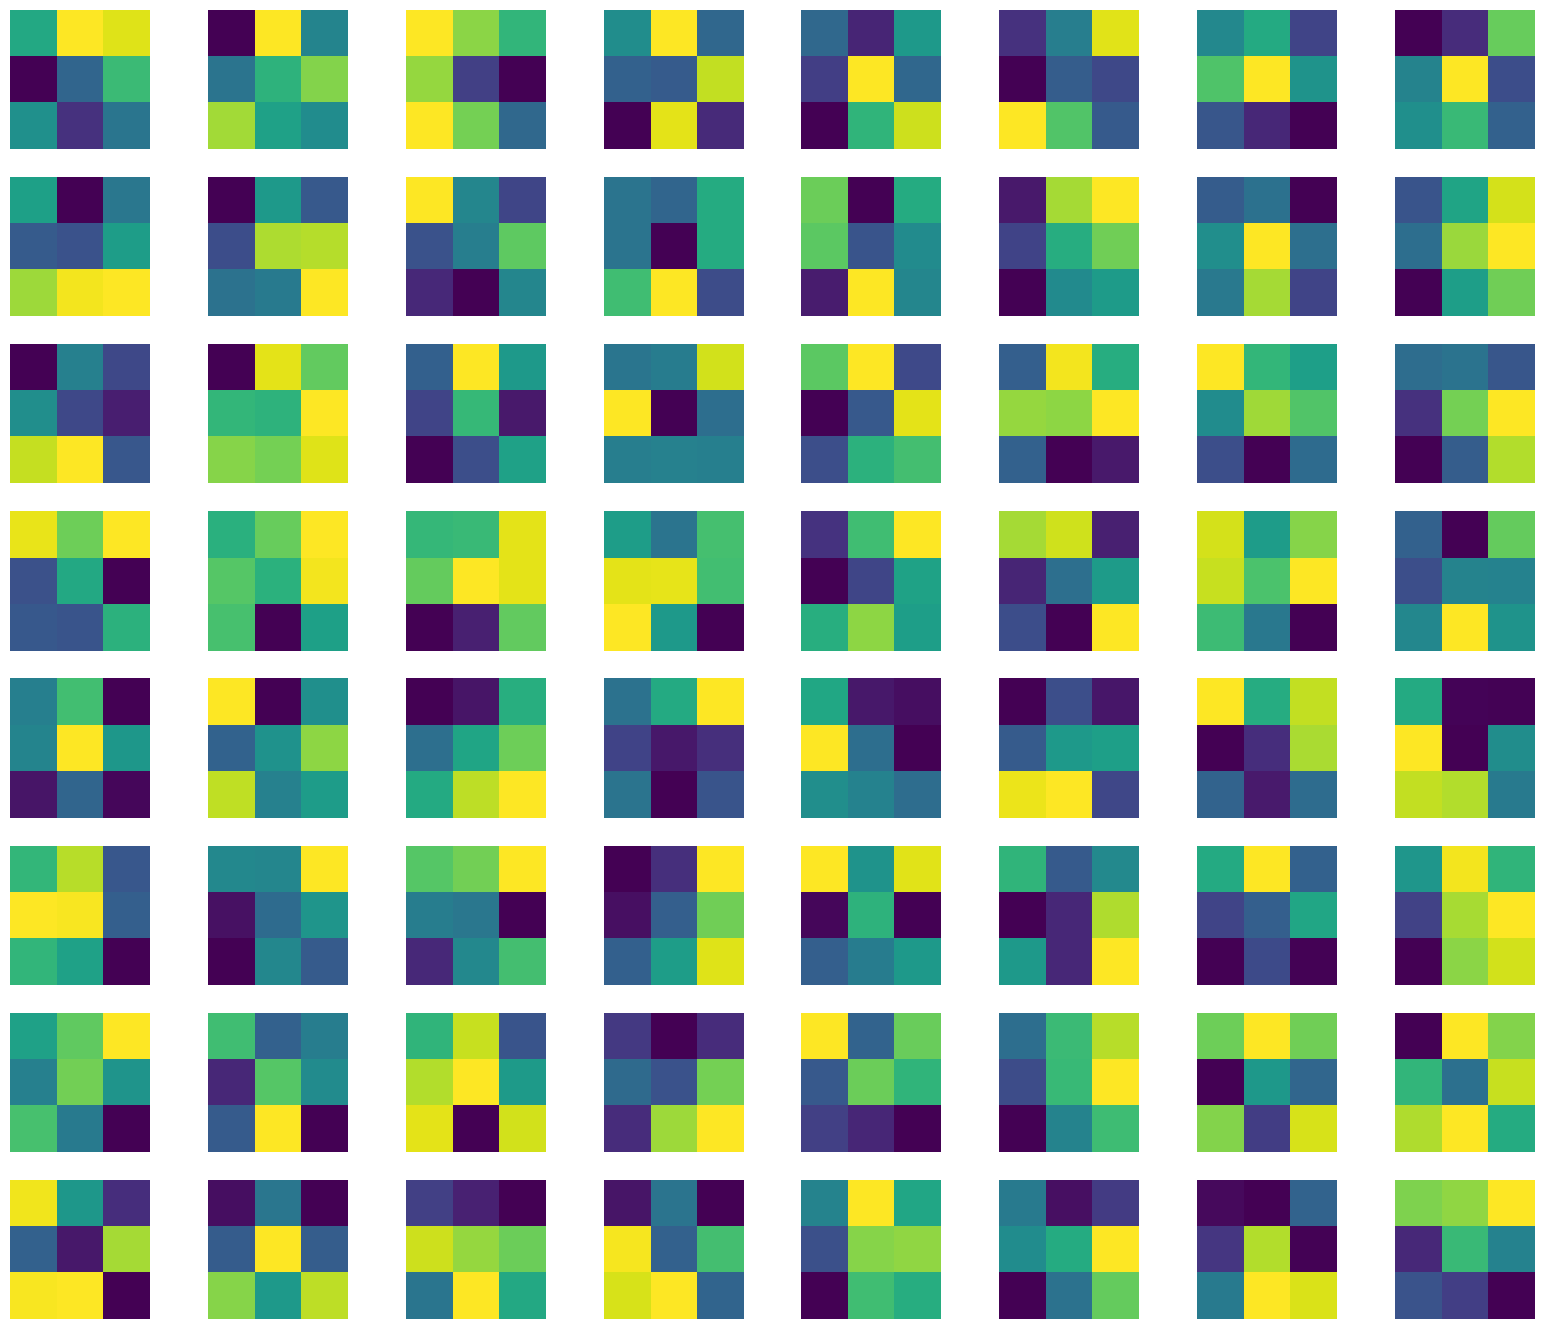

In [80]:
# visualize the first conv layer filters
import math

filters = model_weights[1]
num_filters = filters.shape[0]

cols = 8
rows = math.ceil(num_filters / cols)

plt.figure(figsize=(20, 17))
print(len(model_weights[1]))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(rows, cols, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('output_figures/PlainNet-18-filter1.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6402935..1.5159253].


torch.Size([64, 3, 224, 224])


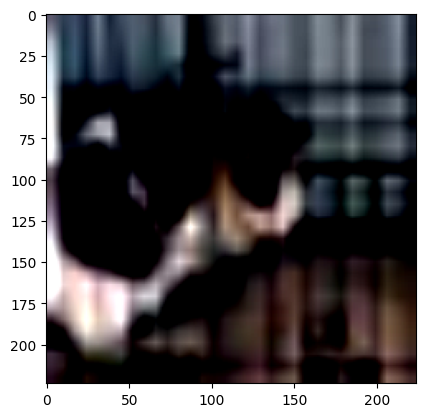

In [81]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1[0].register_forward_hook(get_activation('0'))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

it = iter(train_loader)
images, labels = next(it)

data = images
print(data.shape)

data = torch.unsqueeze(data[0,:,:,:], dim=0)

imshow(torchvision.utils.make_grid(data))

torch.Size([64, 112, 112])


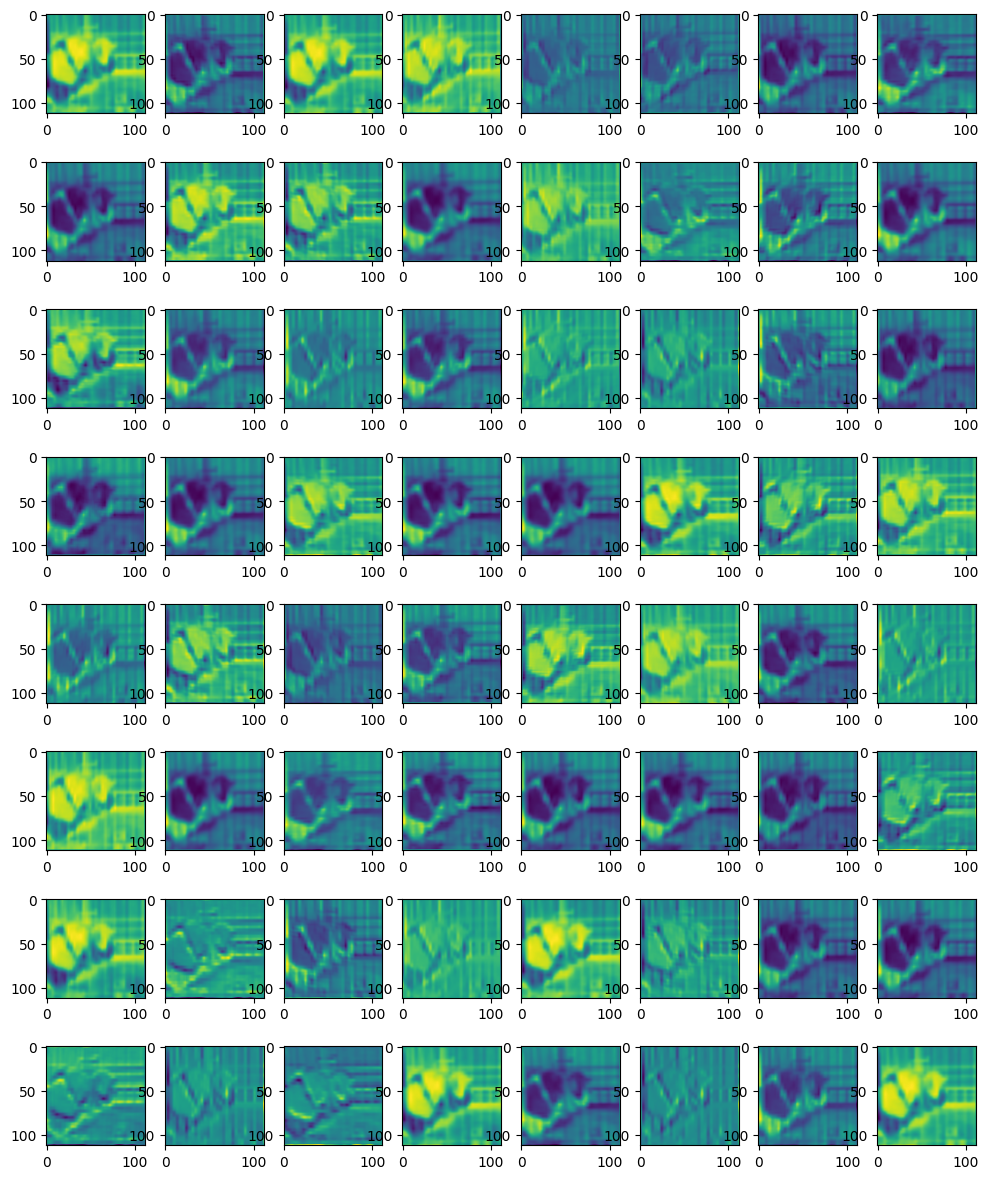

In [82]:
model.eval()
with torch.no_grad():
    model(data)


k=0
act = activation['0'].squeeze()
print(act.shape)
fig,ax = plt.subplots(8,8,figsize=(12, 15))

for i in range(act.size(0)//8):
       for j in range(act.size(0)//8):
          ax[i,j].imshow(act[k].detach().cpu().numpy())
          k+=1    
          plt.savefig('output_figures/PlainNet-18-fm1.png')

#### PlainNet-34

In [83]:
model = PlainNet(num_classes, layers=[6, 7, 11, 5])
model.load_state_dict(torch.load('models/plain-34-sd.bin', map_location=torch.device('cpu')))
model

PlainNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


Total convolutional layers: 34
64


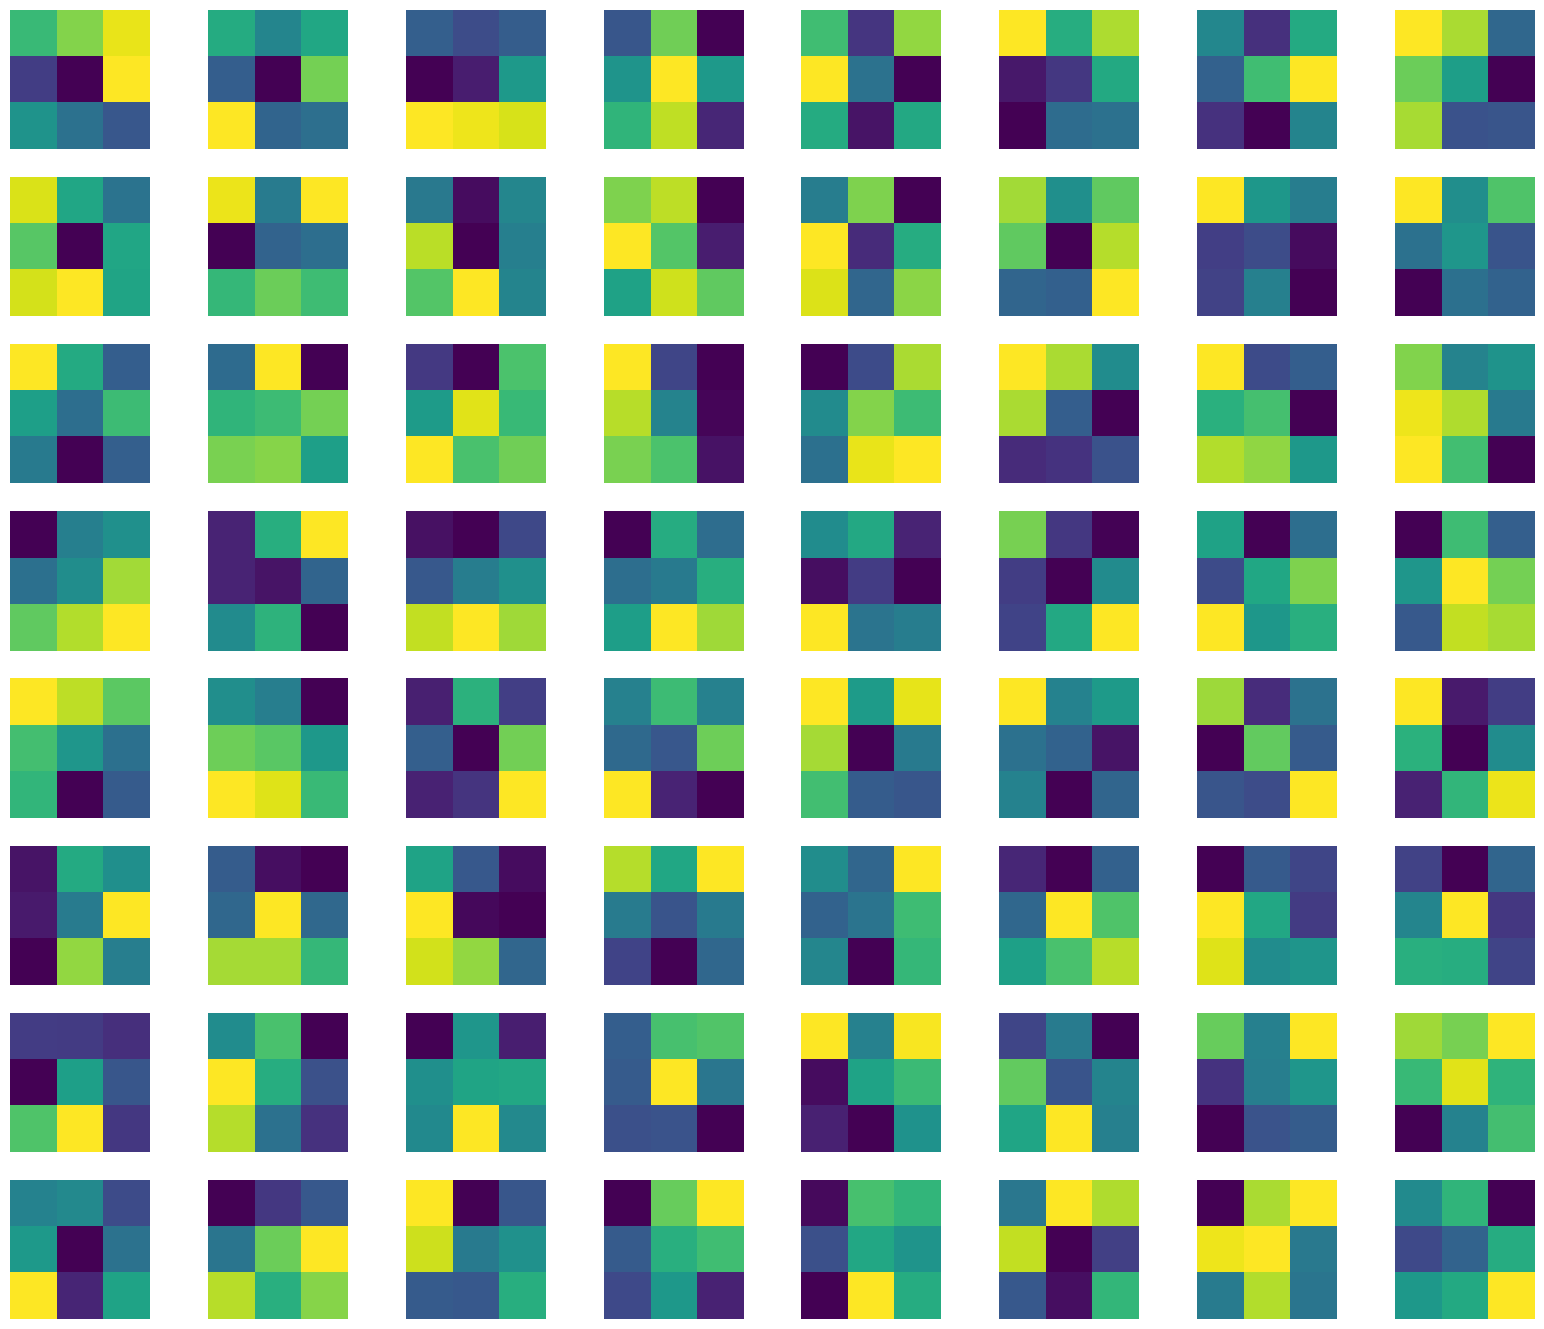

In [84]:
model_weights = [] 
conv_layers = [] 
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i]:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

# visualize the first conv layer filters
import math

filters = model_weights[1]
num_filters = filters.shape[0]

cols = 8
rows = math.ceil(num_filters / cols)

plt.figure(figsize=(20, 17))
print(len(model_weights[1]))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(rows, cols, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('output_figures/PlainNet-34-filter1.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7091274..1.8768656].


torch.Size([64, 3, 224, 224])


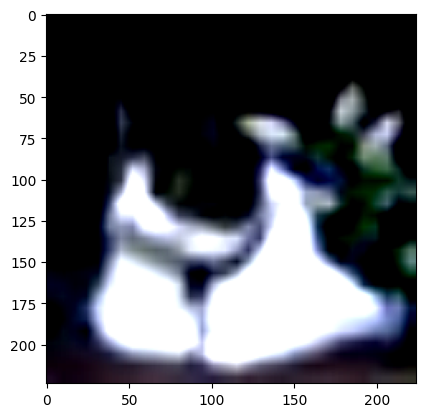

torch.Size([64, 112, 112])


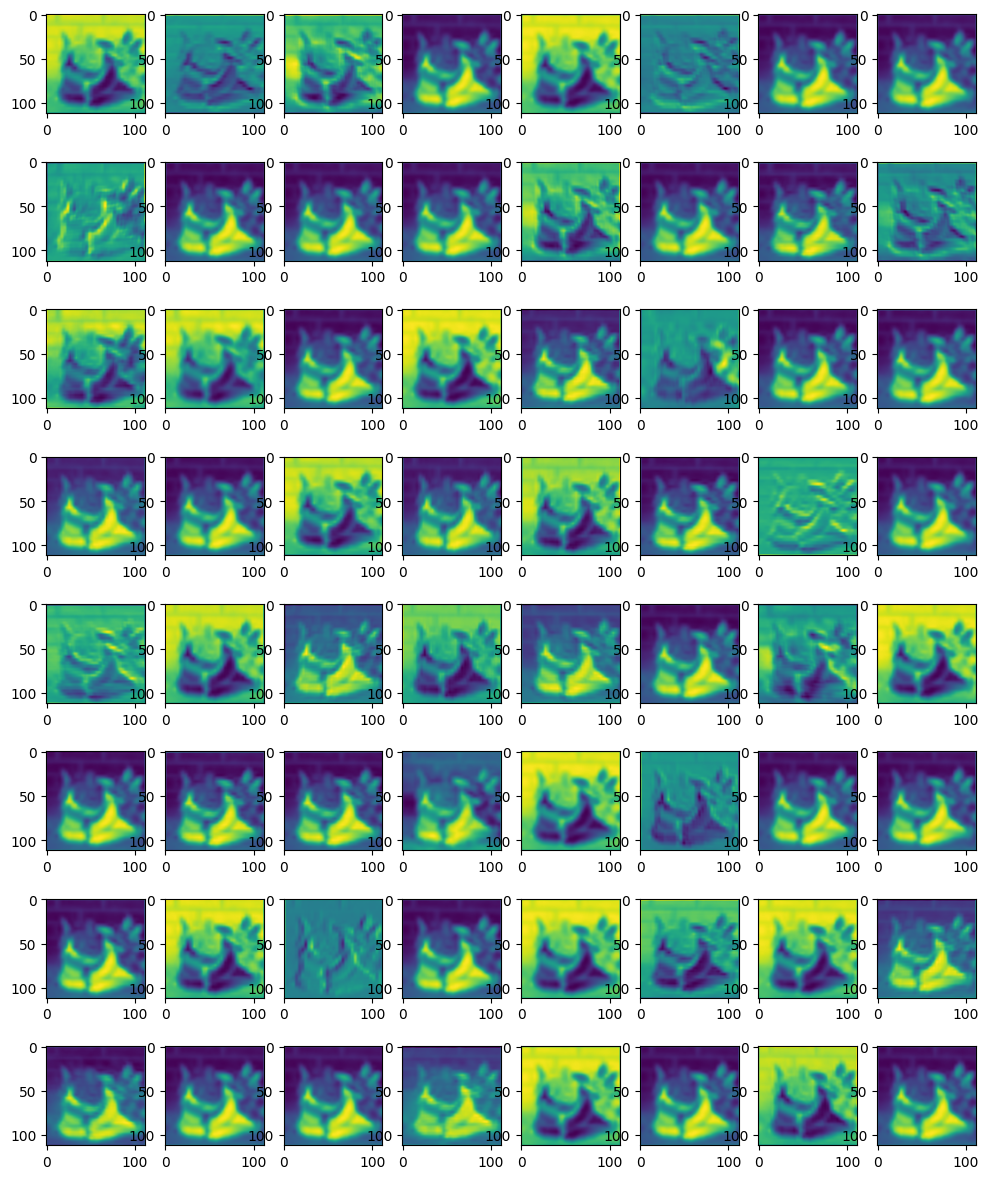

In [85]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1[0].register_forward_hook(get_activation('0'))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

it = iter(train_loader)
images, labels = next(it)

data = images
print(data.shape)

data = torch.unsqueeze(data[0,:,:,:], dim=0)

imshow(torchvision.utils.make_grid(data))

model.eval()
with torch.no_grad():
    model(data)


k=0
act = activation['0'].squeeze()
print(act.shape)
fig,ax = plt.subplots(8,8,figsize=(12, 15))

for i in range(act.size(0)//8):
       for j in range(act.size(0)//8):
          ax[i,j].imshow(act[k].detach().cpu().numpy())
          k+=1    
          plt.savefig('output_figures/PlainNet-34-fm1.png')

#### Resnet-34

In [86]:
model = ResNet(ResidualBlock, [3,4,6,3])
model.load_state_dict(torch.load('models/resnet-34-sd.bin', map_location='cpu'))
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Total convolutional layers: 36
64


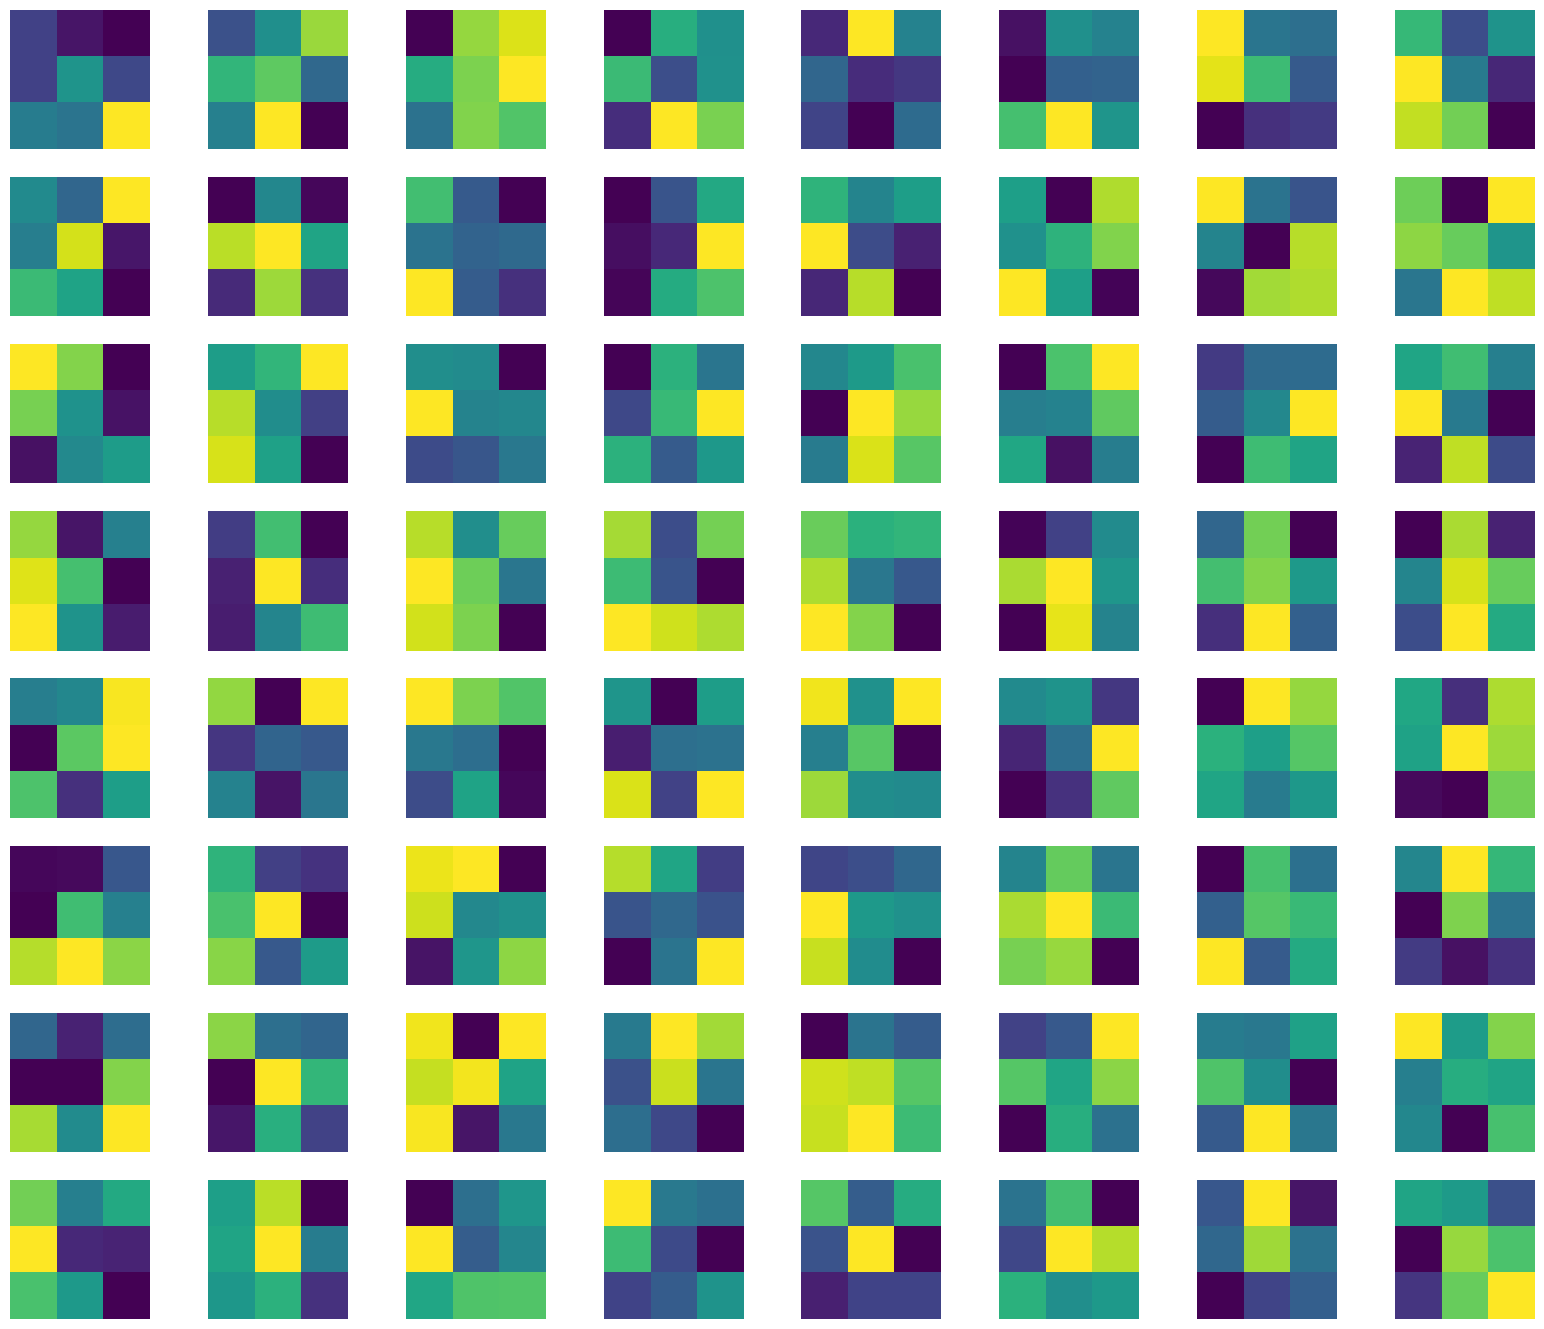

In [87]:
model_weights = []
conv_layers = []

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        counter += 1
        model_weights.append(layer.weight)
        conv_layers.append(layer)

print(f"Total convolutional layers: {counter}")

# visualize the first conv layer filters
import math

filters = model_weights[0]
num_filters = filters.shape[0]

cols = 8
rows = math.ceil(num_filters / cols)

plt.figure(figsize=(20, 17))
print(len(model_weights[1]))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(rows, cols, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('output_figures/ResNet-34-filter1.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8768656].


torch.Size([64, 3, 224, 224])


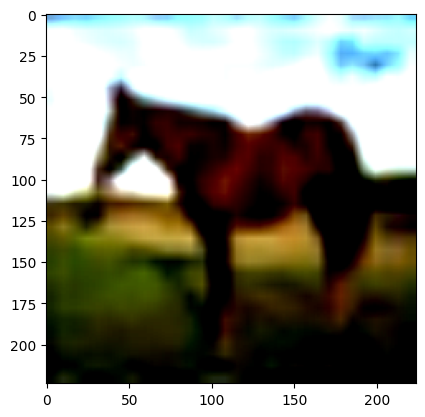

torch.Size([128, 28, 28])


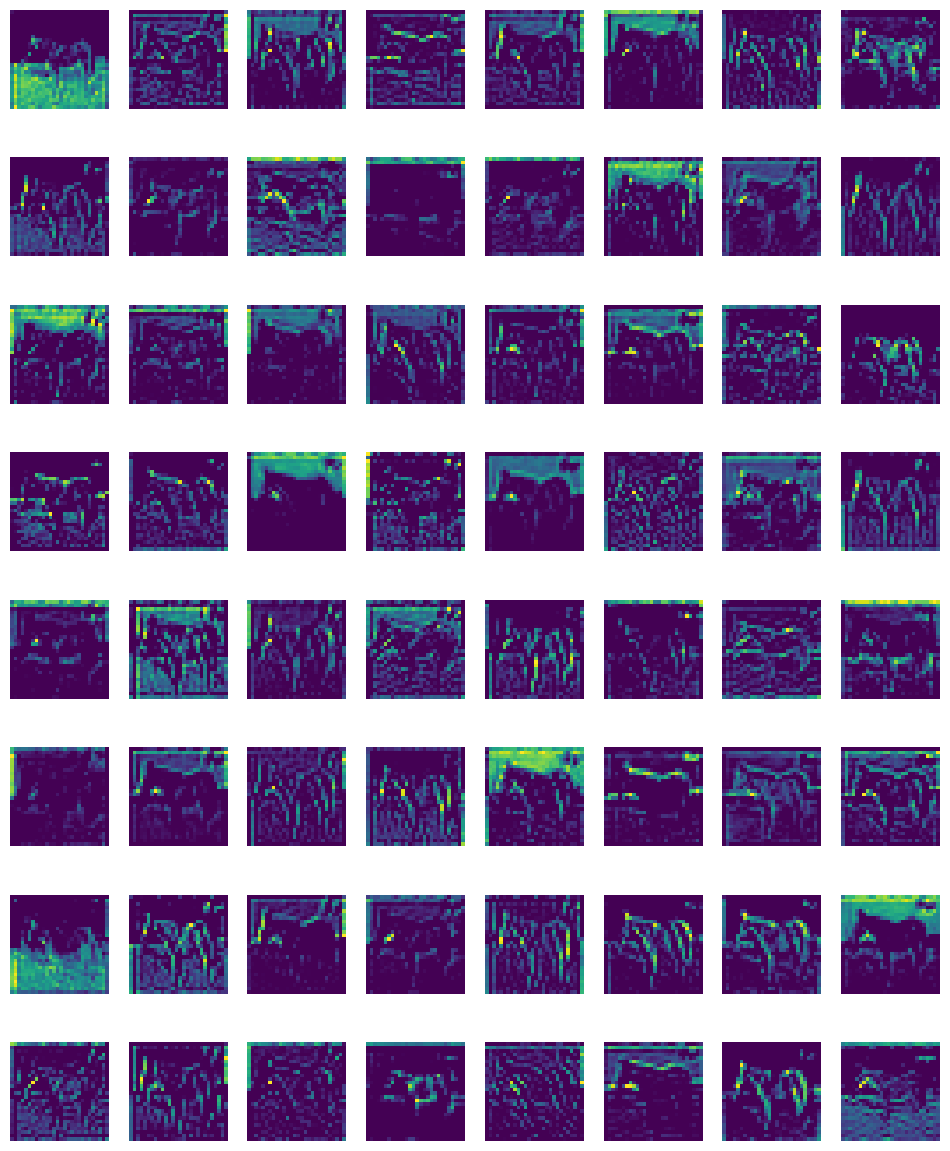

In [88]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1[0].register_forward_hook(get_activation('0'))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

it = iter(train_loader)
images, labels = next(it)

data = images
print(data.shape)

data = torch.unsqueeze(data[0,:,:,:], dim=0)

imshow(torchvision.utils.make_grid(data))

model.eval()
with torch.no_grad():
    model(data)


k = 0
act = activation['0'].squeeze()
print(act.shape)

fig, ax = plt.subplots(8, 8, figsize=(12, 15))

for i in range(8):
    for j in range(8):
        ax[i, j].imshow(act[k].cpu().numpy())
        ax[i, j].axis('off')
        k += 1

plt.savefig('output_figures/ResNet-34-fm1.png')

#### ResNet-50

In [89]:
model = ResNet(Bottleneck, [3, 4, 6, 3])
model.load_state_dict(torch.load('models/resnet-50-sd.bin', map_location='cpu'))
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv3): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.

Total convolutional layers: 53


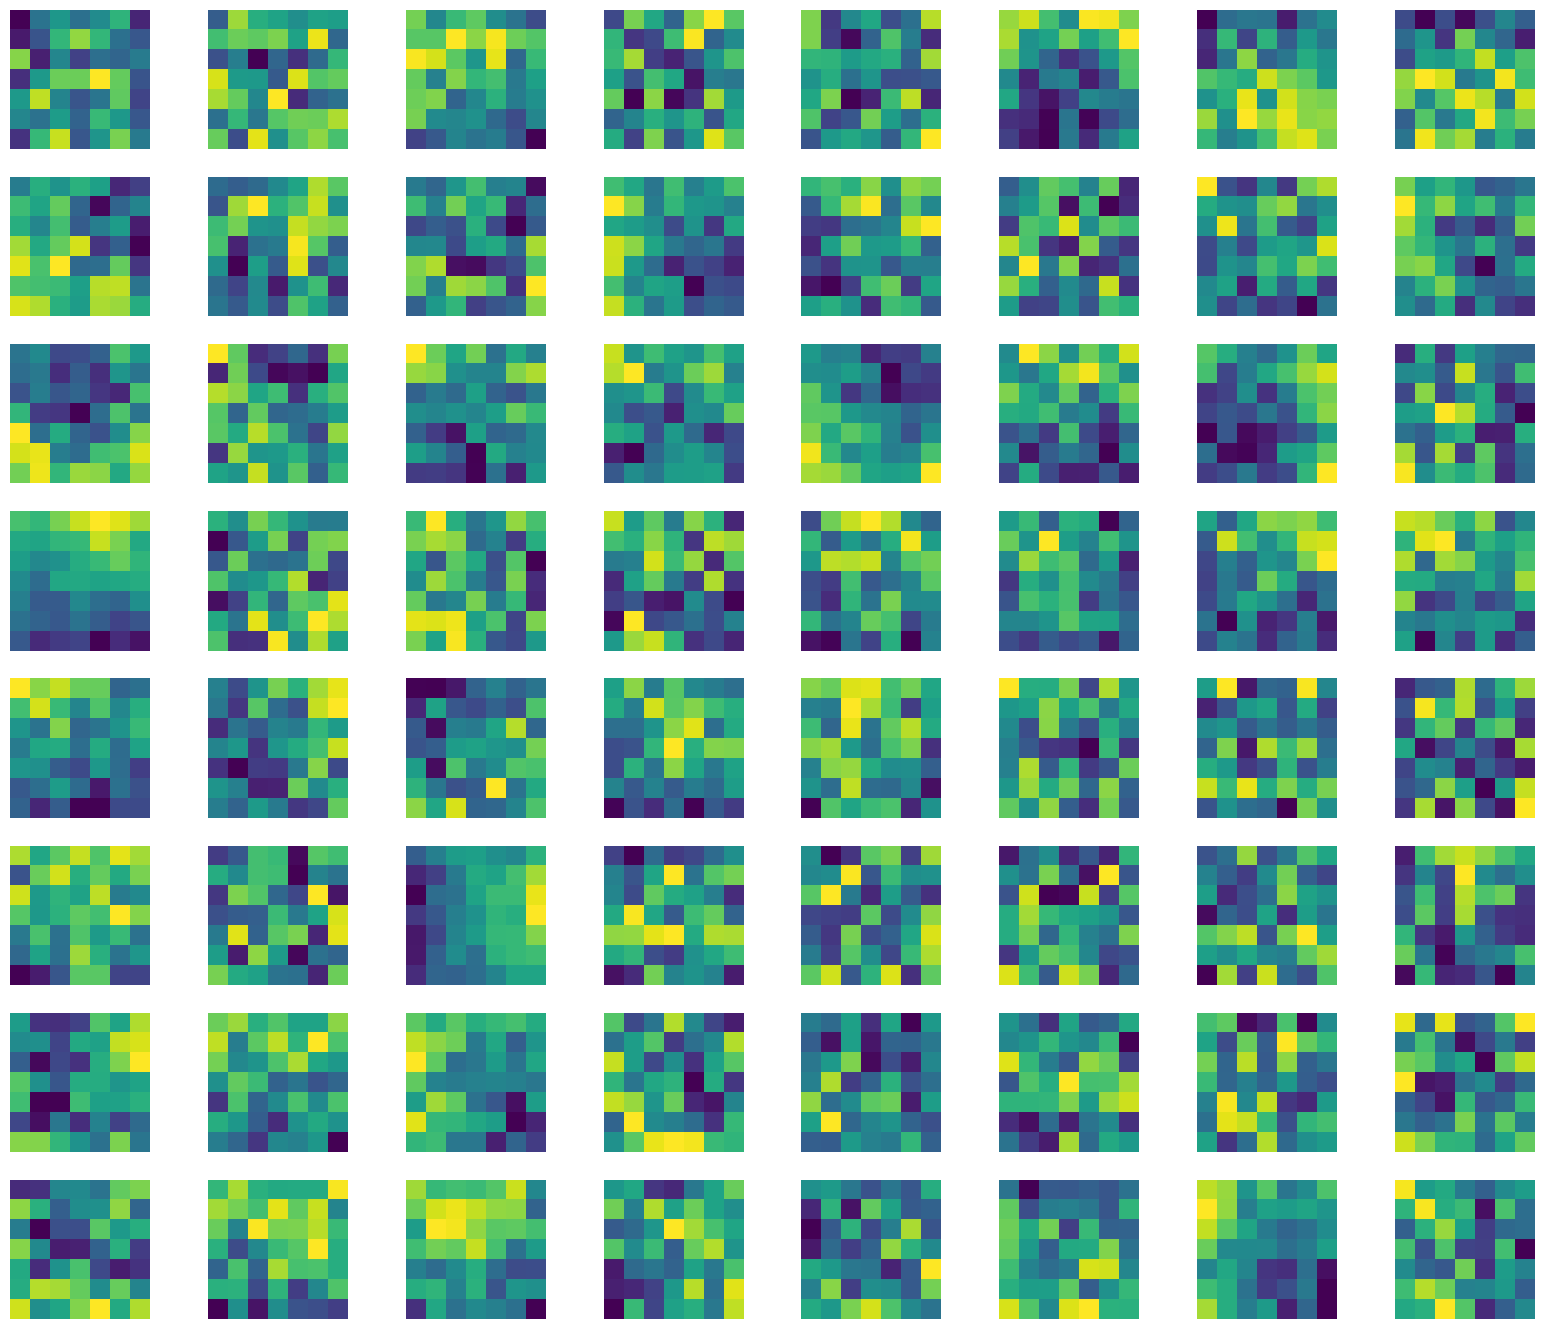

In [90]:
model_weights = []
conv_layers = []

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        counter += 1
        model_weights.append(layer.weight)
        conv_layers.append(layer)

print(f"Total convolutional layers: {counter}")

# visualize the first conv layer filters
import math

filters = model_weights[0]   # first conv layer
num_filters = filters.shape[0]

cols = 8
rows = math.ceil(num_filters / cols)

plt.figure(figsize=(20, 17))

for i, filter in enumerate(filters): 
    plt.subplot(rows, cols, i+1)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')

plt.savefig('output_figures/ResNet-50-filter1.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42534876..1.8671105].


torch.Size([64, 3, 224, 224])


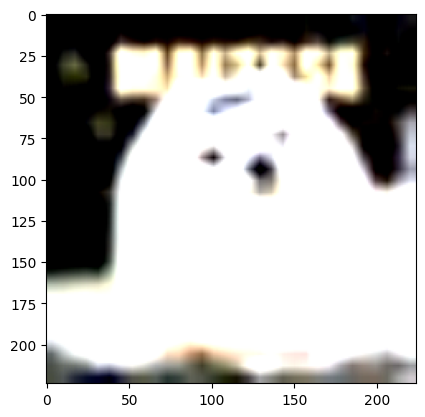

torch.Size([512, 28, 28])


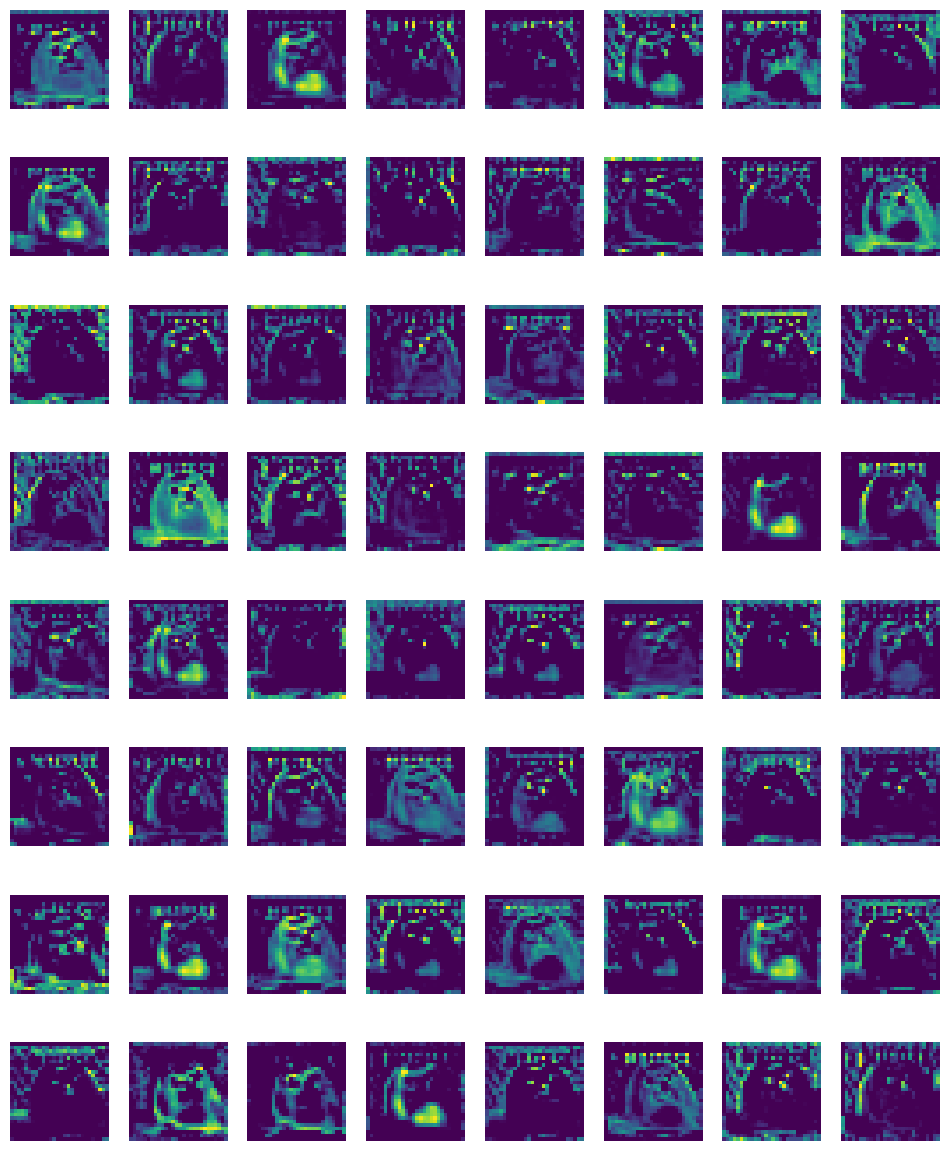

In [91]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1[0].register_forward_hook(get_activation('0'))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

it = iter(train_loader)
images, labels = next(it)

data = images
print(data.shape)

data = torch.unsqueeze(data[0,:,:,:], dim=0)

imshow(torchvision.utils.make_grid(data))

model.eval()
with torch.no_grad():
    model(data)

k = 0
act = activation['0'].squeeze()
print(act.shape)

fig, ax = plt.subplots(8, 8, figsize=(12, 15))

for i in range(8):
    for j in range(8):
        ax[i, j].imshow(act[k].cpu().numpy())
        ax[i, j].axis('off')
        k += 1

plt.savefig('output_figures/PlainNet-50-fm1.png')
plt.show()